In [1]:
from astropy.io import fits 
import pandas as pd
import matplotlib.pyplot as plt
#import smplotlib
import numpy as np
import torch 
from spender.data.sdss import BOSS
import os 

In [4]:
filename = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra/7595/spec-7595-56957-0005.fits'

hdulist = fits.open(filename)
data = hdulist[1].data
loglam = data['loglam']
wave_obs = 10**loglam
flux = data['flux']
spec = data["model"]
ivar = data['ivar']
specinfo = hdulist[2].data[0]
z = None

In [20]:
def prepare_spectrum__(cls, filename, z=None):
    """Prepare spectrum for analysis

    differences: 
        - interpolates spectrum 

    """

    hdulist = fits.open(filename)
    data = hdulist[1].data
    wave_obs = 10**data['loglam']
    spec = data["model"]

    _wave_obs = 10**np.arange(3.578, 3.97, 0.0001)
    _model_flux = np.interp(_wave_obs, wave_obs, spec)

    # remove regions around skylines --> keep? I removed it for now for interpolation. 

    extended_return = False
    if z is None:
        # get plate, mjd, fiberid info
        specinfo = hdulist[2].data[0]
        # get redshift and error
        z = torch.tensor(specinfo["Z"])
        zerr = torch.tensor(specinfo["Z_ERR"])
        extended_return = True

    # normalize spectrum:
    # for redshift invariant encoder: select norm window in restframe
    wave_rest = _wave_obs / (1 + z)

    # flatish region that is well observed out to z ~ X
    sel = (wave_rest > 2000) & (wave_rest < 2500)
    if sel.count_nonzero() == 0: 
        norm = 0
    else: 
        norm = np.median(_model_flux[sel])

    # remove spectra (from training) for which no valid norm could be found
    if not np.isfinite(norm):
        norm = 0
    else:
        _model_flux /= norm

    w = np.zeros_like(_model_flux)

    if extended_return:
        return torch.from_numpy(_model_flux), torch.from_numpy(w), torch.from_numpy(np.array([norm])), torch.from_numpy(np.array([z])), torch.from_numpy(np.array([zerr]))
    else: 
        return torch.from_numpy(_model_flux), torch.from_numpy(w), torch.from_numpy(np.array([norm])) 

Text(0, 0.5, 'Flux')

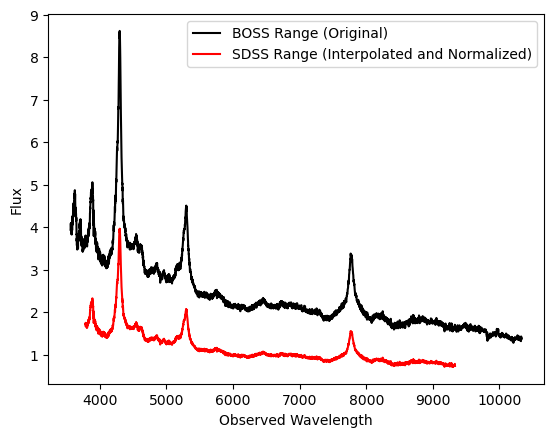

In [22]:
plt.plot(wave_obs, spec, color='black', label='BOSS Range (Original)')
plt.plot(_wave_obs, _model_flux, color='red', label='SDSS Range (Interpolated and Normalized)')
plt.legend()
plt.xlabel('Observed Wavelength')
plt.ylabel('Flux')

## Test of Spender

In [23]:
github = "pmelchior/spender"
sdss, model = torch.hub.load(github, 'sdss_II', map_location=torch.device('cpu'))

data_dir = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra'

ids = [(7595, 56957, 5)]

spec, w, z, norm, zerr = BOSS.make_batch(data_dir, ids)

with torch.no_grad():
    s, spec_rest, spec_reco = model._forward(spec, instrument=sdss, z=z)

s, spec_rest, spec_reco = s.numpy()[0], spec_rest.numpy()[0], spec_reco.numpy()[0]

print(len(s), len(spec_rest), len(spec_reco))

6 7000 3921


Using cache found in /Users/yaroslav/.cache/torch/hub/pmelchior_spender_main


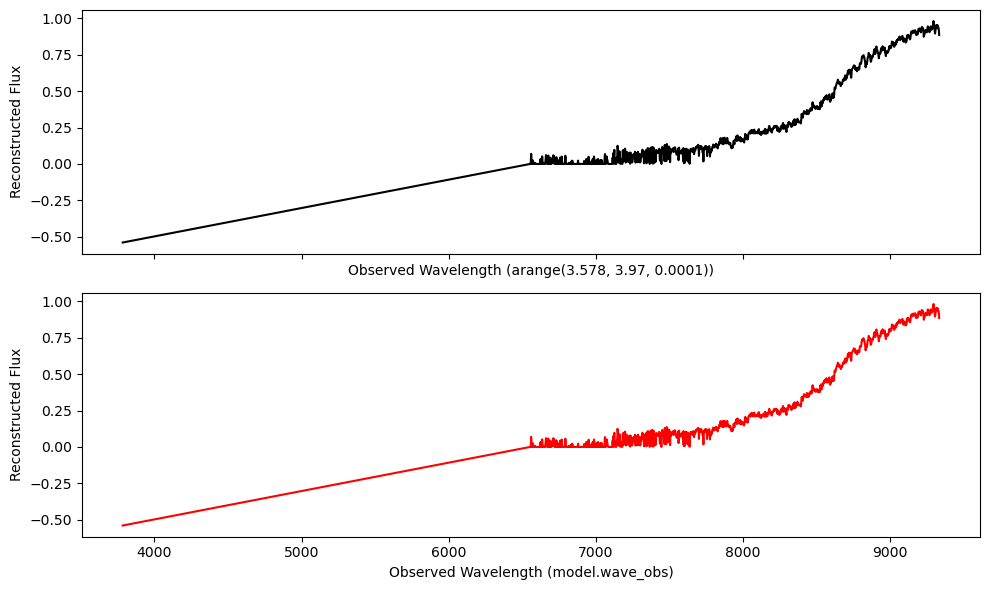

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)

#axs[0].plot(wave_raw, flux, label='Raw Flux')
#axs[0].plot(wave_raw, model_flux, label='Model FLux', color='black')

axs[0].plot(10 ** np.arange(3.578, 3.97, 0.0001), spec_reco, color='black')
axs[1].plot(model.wave_obs.numpy(), spec_reco, color='red')

axs[0].set(xlabel='Observed Wavelength (arange(3.578, 3.97, 0.0001))', ylabel='Reconstructed Flux')

axs[1].set(xlabel='Observed Wavelength (model.wave_obs)', ylabel='Reconstructed Flux')

fig.tight_layout()

# This shows there's a bug in the code that it's forcing the BOSS Spectra back to its original wavelength range. Also i'm so confused why spec_reco values are so small. 